In [1]:
from obp.policy import Random, BernoulliTS
from obp.ope import RegressionModel
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from tqdm import tqdm

from dataset import ModifiedZOZOTOWNBanditDataset
from estimator import InversePropensityScore as IPS
from estimator import MarginalizedIPS as MIPS
from estimator import DoublyRobust as DR
from estimator_tuning import SLOPE
from importance_weight import marginal_weight
from lower_bound import estimate_student_t_lower_bound
from util import (
    ActionEmbedOffPolicyEvaluation, 
    aggregate_simulation_results, 
    visualize_mean_squared_error
)

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# settings

sample_sizes = [5000]

n_actions=80
len_list=3
random_state=12345
n_seeds=50
n_cat_dim=4
ope_estimators = [IPS(estimator_name="IPS"), DR(estimator_name="DR"), MIPS(estimator_name="MIPS (true)")]
ope_estimators_tune = [
    SLOPE(
        estimator=MIPS(estimator_name="MIPS (true)-SLOPE"),
        hyper_param=np.arange(n_cat_dim),
        param_name="action_embed_dim",
        lower_bound_func=estimate_student_t_lower_bound,
        weight_func=marginal_weight,
        tuning_method="greedy_combination",
        min_combination=1
    )
]

palette={
    "IPS": "tab:red",
    "DR": "tab:blue",
    "MIPS (true)": "tab:gray",
    "MIPS (true)-SLOPE": "tab:green"
}

In [3]:
pi_ur = Random(
    n_actions=n_actions,
    len_list=len_list,
    random_state=random_state,
)
pi_ts = BernoulliTS(
    n_actions=n_actions,
    len_list=len_list,
    random_state=random_state,
    is_zozotown_prior=True,
    campaign="all",
)

# calc ground-truth policy value (on-policy)
policy_value = ModifiedZOZOTOWNBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy="bts", campaign="all"
)

# define a dataset class
dataset = ModifiedZOZOTOWNBanditDataset(
    behavior_policy="random",
    campaign="all",
)

result_df_list = []
for sample_size in sample_sizes:
    
    pi_b = pi_ur.compute_batch_action_dist(n_rounds=sample_size)
    pi_b = pi_b.reshape(sample_size, n_actions * len_list) / len_list

    pi_e = pi_ts.compute_batch_action_dist(n_rounds=sample_size)
    pi_e = pi_e.reshape(sample_size, n_actions * len_list) / len_list

    result_list = []
    for seed in tqdm(range(n_seeds), desc=f"sample_size={sample_size}..."):

        val_bandit_data = dataset.sample_bootstrap_bandit_feedback(
            sample_size=sample_size,
            random_state=seed
        )
        val_bandit_data["pi_b"] = pi_b
        regression_model = RegressionModel(
            n_actions=dataset.n_actions,
            base_model=RandomForestClassifier(
                n_estimators=10, max_samples=0.8, random_state=12345
            ),
        )
        estimated_rewards = regression_model.fit_predict(
            context=val_bandit_data["context"],  # context; x
            action=val_bandit_data["action"],  # action; a
            reward=val_bandit_data["reward"],  # reward; r
            n_folds=2,
            random_state=12345,
        )
        estimated_rewards = estimated_rewards.squeeze(axis=2)

        # off policy evaluation
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_bandit_data,
            ope_estimators=ope_estimators,
            ope_estimators_tune=ope_estimators_tune
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=pi_e, estimated_rewards=estimated_rewards)

        result_list.append(estimated_policy_values)

    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=sample_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.
INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.
sample_size=5000...: 100% 50/50 [02:24<00:00,  2.88s/it]


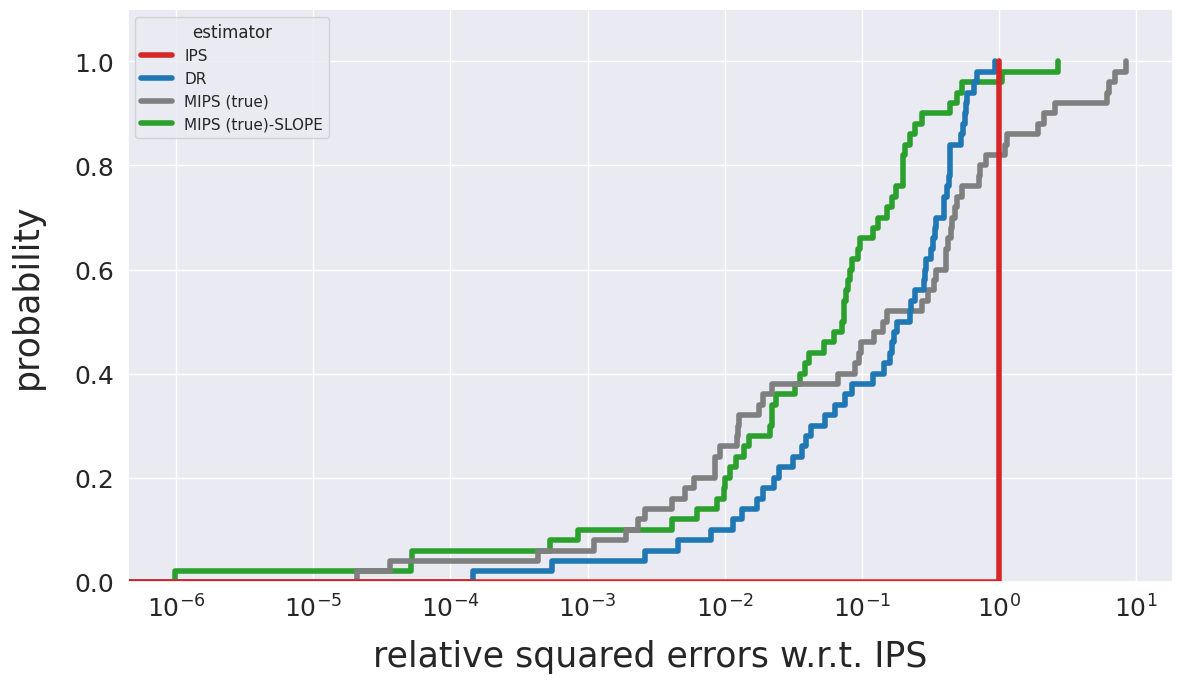

In [4]:
### CDF of relative SE ###
sample_size_mask = (result_df["x"] == 5000)

rel_result_df = result_df[sample_size_mask].copy()
ips_se = rel_result_df[rel_result_df['estimator'] == 'IPS'].set_index('index')['se']
rel_result_df['baseline_se'] = rel_result_df['index'].map(ips_se)
rel_result_df['rel_se'] = rel_result_df['se'] / rel_result_df['baseline_se']
rel_result_df = rel_result_df[['estimator', 'rel_se']]
fig, ax = plt.subplots(figsize=(12, 7), tight_layout=True)
sns.ecdfplot(
    linewidth=4,
    palette=palette,
    data=rel_result_df,
    x="rel_se",
    hue="estimator",
    ax=ax,
)

# yaxis
ax.set_ylabel("probability", fontsize=25)
ax.set_ylim([0,1.1])
ax.tick_params(axis="y", labelsize=18)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("relative squared errors w.r.t. IPS", fontsize=25)
ax.tick_params(axis="x", labelsize=18)
ax.xaxis.set_label_coords(0.5, -0.1)

In [8]:
ope.ope_estimators_tune[0].best_param

{2}